# Make necessary imports

In [1]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation


import sys, time
import numpy as np
sys.path.insert(0, '../')
import tensorflow as tf
from library.datasets import cifar10
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from library.utils import file_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

None


In [2]:
total_time = 0

# Step 1.1: Load CIFAR 10 Dataset

In [3]:
cifar10_dataset = cifar10.CIFAR10(one_hot_encode=True, num_images=1.0, image_mode='rgb_float',
                                  train_validate_split=None, endian='little')
cifar10_dataset.load_data(train=True, test=True, data_directory='./datasets/cifar10/')

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 50000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5
Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 3.4019 seconds


True

# Step 1.2: Make test train split

In [4]:
X = cifar10_dataset.train.images
Y = cifar10_dataset.train.one_hot_labels
X_test = cifar10_dataset.test.images
Y_test = cifar10_dataset.test.one_hot_labels

X_train, X_validate, Y_train, Y_validate = train_test_split(X, Y, test_size=0.2, random_state=1)


# Step 1.3: Print image shapes

In [5]:
one_hot = True
make_image = True
mode='rgb'

print("Train image details:")
print('Train data shape:', X.shape)
print('Train labels shape:', Y.shape)

print("\nValidation image details:")
print('Validation data shape:', X_validate.shape)
print('Validation labels shape:', Y_validate.shape)

print("\nTest image details:")
print('Test data shape:', X_test.shape)
print('Test labels shape:', Y_test.shape)


print("\nTest image samples:---------------------------\n")
print('Train data shape:\n', X_test[0])
print('\nTrain labels shape:\n', Y_test[0])

Train image details:
Train data shape: (50000, 32, 32, 3)
Train labels shape: (50000, 10)

Validation image details:
Validation data shape: (10000, 32, 32, 3)
Validation labels shape: (10000, 10)

Test image details:
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 10)

Test image samples:---------------------------

Train data shape:
 [[[ 0.61960784  0.43921569  0.19215686]
  [ 0.62352941  0.43529412  0.18431373]
  [ 0.64705882  0.45490196  0.2       ]
  ..., 
  [ 0.5372549   0.37254902  0.14117647]
  [ 0.49411765  0.35686275  0.14117647]
  [ 0.45490196  0.33333333  0.12941176]]

 [[ 0.59607843  0.43921569  0.2       ]
  [ 0.59215686  0.43137255  0.15686275]
  [ 0.62352941  0.44705882  0.17647059]
  ..., 
  [ 0.53333333  0.37254902  0.12156863]
  [ 0.49019608  0.35686275  0.1254902 ]
  [ 0.46666667  0.34509804  0.13333333]]

 [[ 0.59215686  0.43137255  0.18431373]
  [ 0.59215686  0.42745098  0.12941176]
  [ 0.61960784  0.43529412  0.14117647]
  ..., 
  [ 0.54509804  0.38

# Step 1.4 Display train and test images


Plotting CIFAR 10 Train Dataset


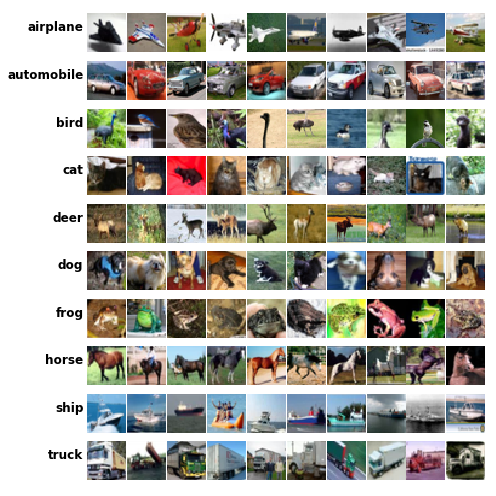

Plotting CIFAR 10 Test Dataset


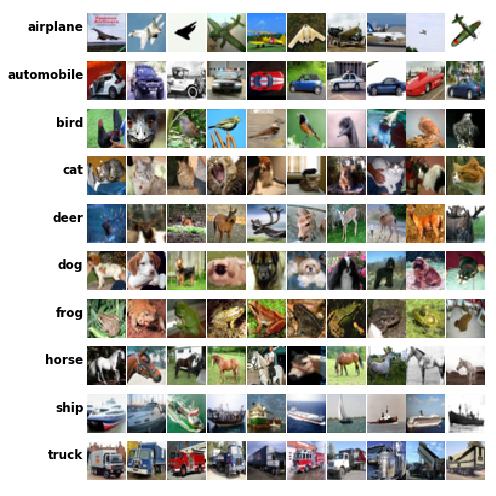

In [6]:
cifar10_dataset.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))


# Step 1.5 Display train images with labels

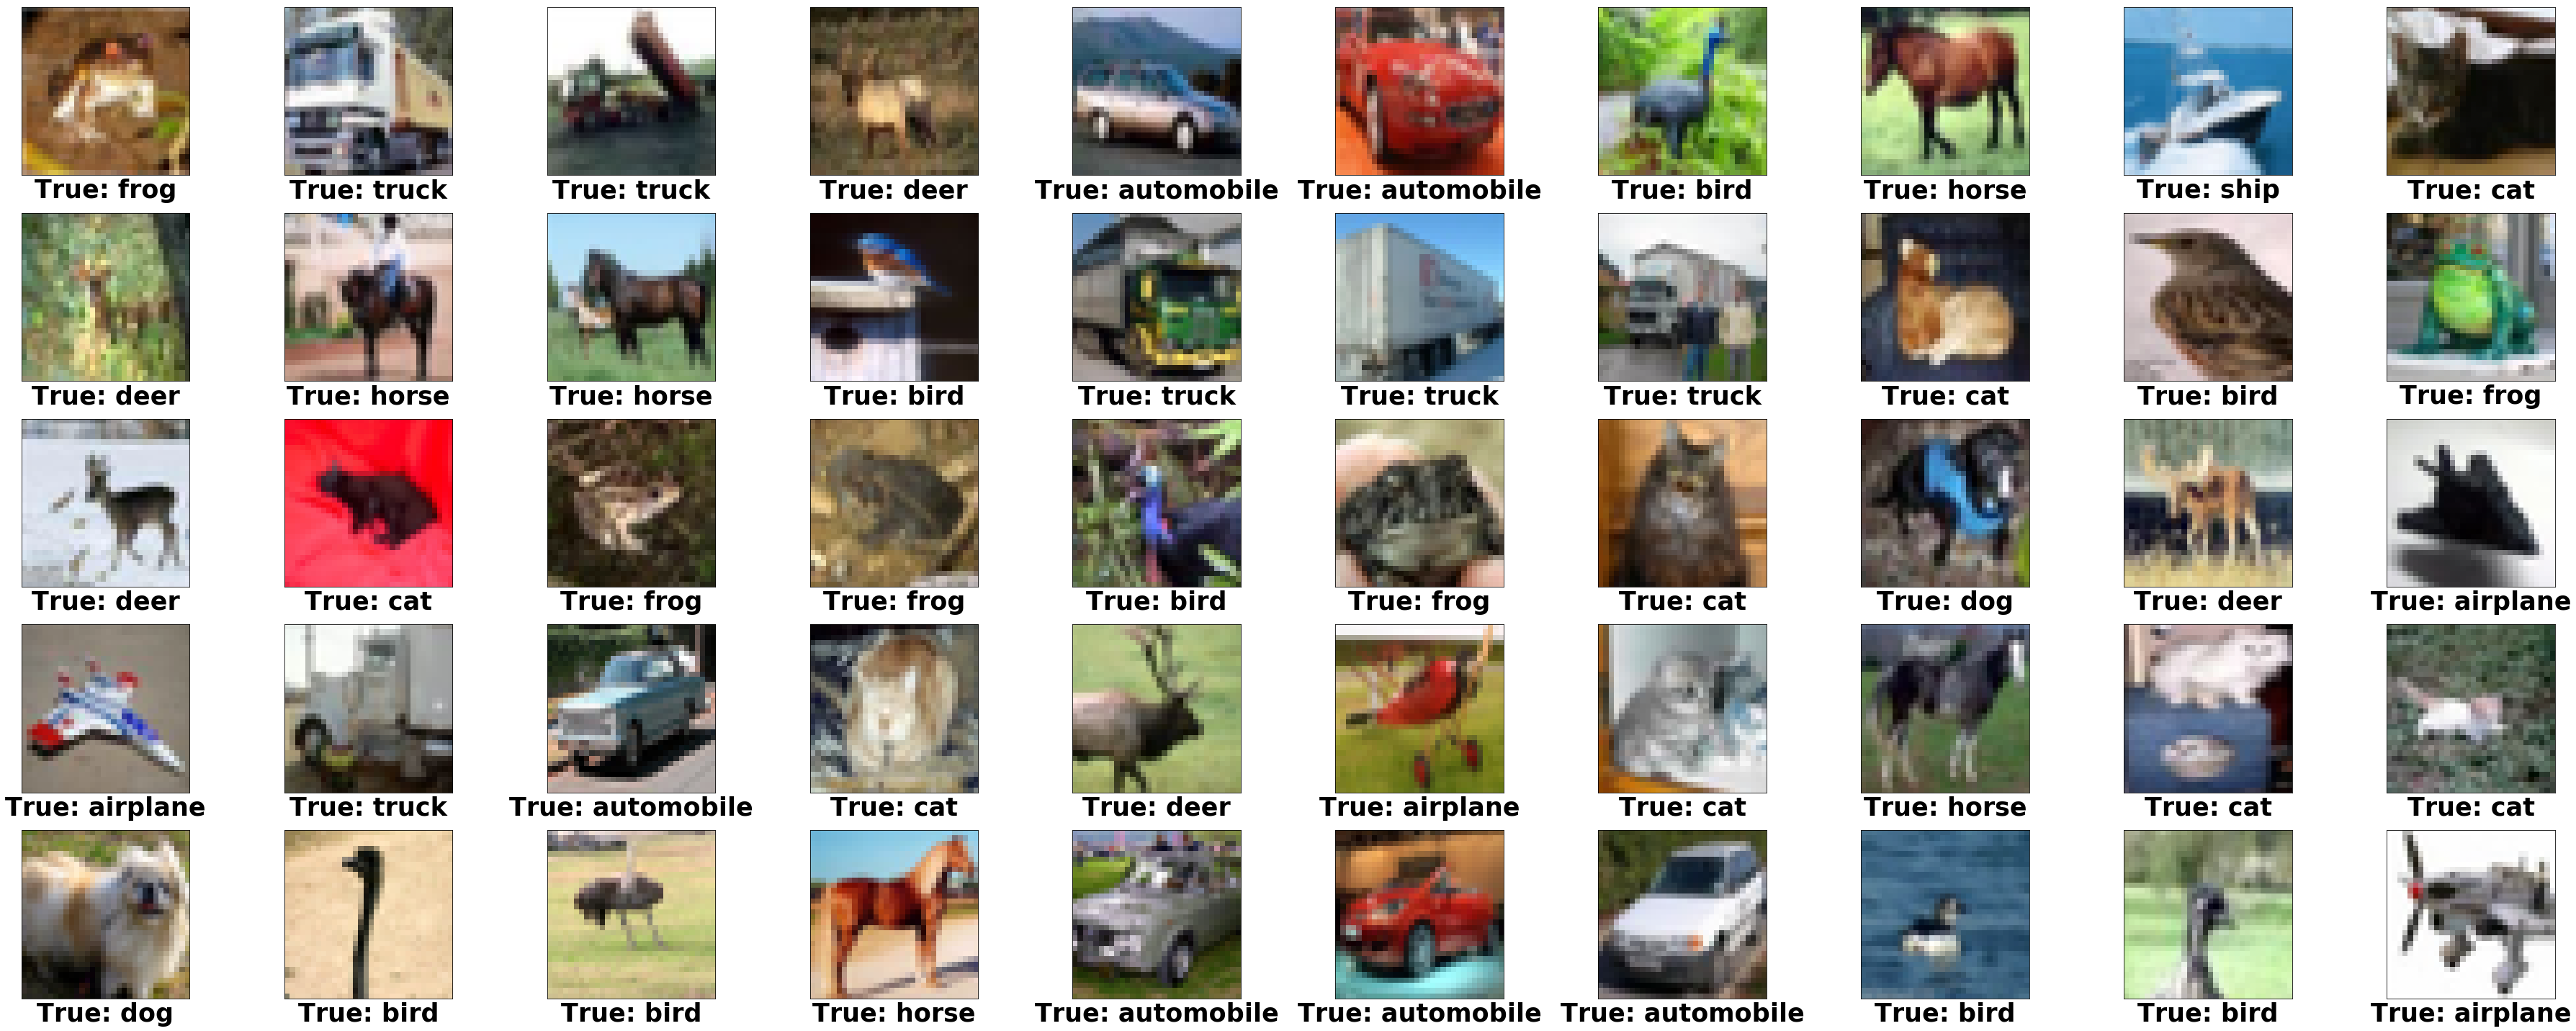

True

In [7]:
cifar10_dataset.plot_images(cifar10_dataset.train.data[:50, :], cifar10_dataset.train.class_names[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=True)

In [8]:
exp_no = 3
file_no = 20
dataset = 'cifar10'


In [9]:
model_dir='./logs/model1'

In [10]:
log_dir = '../logs/' + dataset + '/' + str(file_no).zfill(2) + '_tf_cnn/exp_no_' + str(exp_no) + '/'
#ck_path = '../ckpts/' + 'ckpt_tf_cnn/exp_no_' + str(exp_no) + '/'+'model.tfl.ckpt'
#cptfile = model.tfl.ckpt
ck_path = log_dir + 'model.tfl.ckpt'
output_directory = '../'
log_file = log_dir + 'tflearncnn_classifier.ckpt'
print('Writing tensorboard logs to %s' %log_file)
print('view logs by running tensorboard: ', end='')
print('\"tensorboard --logdir=\'./10_tf_cnn/\' --port 61111\"')

Writing tensorboard logs to ../logs/cifar10/20_tf_cnn/exp_no_3/tflearncnn_classifier.ckpt
view logs by running tensorboard: "tensorboard --logdir='./10_tf_cnn/' --port 61111"


# Step 1.6 Image augmentation and processing

In [11]:
# Real-time data preprocessing
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

In [12]:
# Real-time data augmentation
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

In [13]:
#img_aug.add_random_crop([32, 32], padding=4)

In [14]:
network = input_data(shape=[None, 32, 32, 3],data_preprocessing=img_prep,data_augmentation=img_aug)
#network = input_data(shape=[None, 32, 32, 3])

# Step 2 Model Convolutional Neural network

In [15]:
# accuracy== 0.80589
# network = conv_2d(network, 32, 3, activation='relu')
# network = max_pool_2d(network, 2)
# network = conv_2d(network, 128, 3, activation='relu')
# network = max_pool_2d(network, 2)
# network = conv_2d(network, 512, 3, activation='relu')
# network = max_pool_2d(network, 2)
# network = fully_connected(network, 1024, activation='relu')
# network = dropout(network, 0.5)
# network = fully_connected(network, 10, activation='softmax')
# network = regression(network, optimizer='adam',
#                      loss='categorical_crossentropy',
#                      learning_rate=0.001)


#################################################################
# accuracy == 0.79359999999999997

# network = conv_2d(network, 32, 3, activation='relu')
# network = max_pool_2d(network, 2)
# network = conv_2d(network, 64, 3, activation='relu')
# network = max_pool_2d(network, 2)
# network = conv_2d(network, 128, 3, activation='relu')
# network = max_pool_2d(network, 2)
# network = conv_2d(network, 256, 3, activation='relu')
# network = max_pool_2d(network, 2)
# network = conv_2d(network, 512, 3, activation='relu')
# network = max_pool_2d(network, 2)
# network = fully_connected(network, 1024, activation='relu')
# network = dropout(network, 0.5)
# network = fully_connected(network, 2048, activation='relu')
# network = dropout(network, 0.5)
# network = fully_connected(network, 10, activation='softmax')
# network = regression(network, optimizer='adam',
#                      loss='categorical_crossentropy',
#                      learning_rate=0.001)


##################################################################

#ex3==0.81089999999999995   itern 100 without crop

# iteration 5 without crop 0.73309999999999997
# iteration 5 with crop 0.76

network = conv_2d(network, 32, 3, activation='relu')
network = max_pool_2d(network, 2)
network = conv_2d(network, 64, 3, activation='relu')
network = conv_2d(network, 64, 3, activation='relu')
network = max_pool_2d(network, 2)


network = fully_connected(network, 512, activation='relu')
network = dropout(network, 0.5)
network = fully_connected(network, 10, activation='softmax')

network = regression(network, optimizer='adam',
                      loss='categorical_crossentropy',
                      learning_rate=0.001)



###########################################################



In [16]:
start = time.time()
model = tflearn.DNN(network, tensorboard_verbose=2,tensorboard_dir=log_file,checkpoint_path=ck_path)
#model.load(ck_path)

model.fit(X_train, Y_train, n_epoch=1, shuffle=True,snapshot_epoch=True, validation_set=(X_validate, Y_validate),
          show_metric=True, batch_size=96, run_id='cifar10_cnn')
end = time.time()
print(end-start)

Training Step: 416  | total loss: 1.33743 | time: 66.649s
| Adam | epoch: 001 | loss: 1.33743 - acc: 0.5127 -- iter: 39936/40000
Training Step: 417  | total loss: 1.31879 | time: 68.110s
| Adam | epoch: 001 | loss: 1.31879 - acc: 0.5240 | val_loss: 1.19099 - val_acc: 0.5713 -- iter: 40000/40000
--
INFO:tensorflow:/net/voxel03/misc/me/praneethas/PycharmProjects/object-recognition/logs/cifar10/20_tf_cnn/exp_no_3/model.tfl.ckpt-417 is not in all_model_checkpoint_paths. Manually adding it.
72.24387049674988


# Step 3 : Write the obtained Model to file

In [28]:
output_directory = '../logs/cifar10/' + str(file_no).zfill(2) + '_tfl_cnn_models/' + 'exp_no_' + str(exp_no).zfill(3) + '/'
file_utils.mkdir_p(output_directory)
model_output_path = output_directory + 'model.tflearn'
model.save(model_output_path)


INFO:tensorflow:/net/voxel03/misc/me/praneethas/PycharmProjects/object-recognition/logs/cifar10/20_tfl_cnn_models/exp_no_003/model.tflearn is not in all_model_checkpoint_paths. Manually adding it.


In [32]:
res = model.evaluate(cifar10_dataset.test.images, cifar10_dataset.test.one_hot_labels)

In [33]:
print("test acc:",res)

test acc: [0.48330000000000001]


In [34]:
from library.plot_tools import plot_tools
import numpy as np
import sklearn.metrics as skm


# Step 4 : Validation dataset

Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Confusion matrix, without normalization
[[490 138  28  36   5   2   3  13  88 183]
 [ 11 705   1   6   0   0   2   0  14 247]
 [ 96  91 278 180  39  16 117  33  22 166]
 [ 22  56  39 565  14  18  73  15   8 179]
 [ 36  65 100 159 256   4 152  86   5 144]
 [  8  42  56 508  15 134  45  53   4 130]
 [  4  48  28 125  18   2 592   4   3 163]
 [  5  48  20 156  46  13  27 480   4 213]
 [ 60 153   6  17   1   1   1   2 527 210]
 [  9 127   1  12   0   0   2   7   7 857]]
Normalized confusion matrix
[[ 0.4969574   0.13995943  0.02839757  0.03651116  0.00507099  0.0020284
   0.0030426   0.01318458  0.08924949  0.18559838]
 [ 0.01115619  0.71501014  0.0010142   0.00608519  0.          0.
   0.0020284   0.          0.01419878  0.2505071 ]
 [ 0.09248555  0.08766859  0.26782274  0.1734104   0.03757225  0.01541426
   0.11271676  0.03179191  0.02119461  0.15992293]
 [ 0.02224469  0.05662285  0.03943377  0.57128413  0.01415571  0.0182002
   0.07381193  0.015166

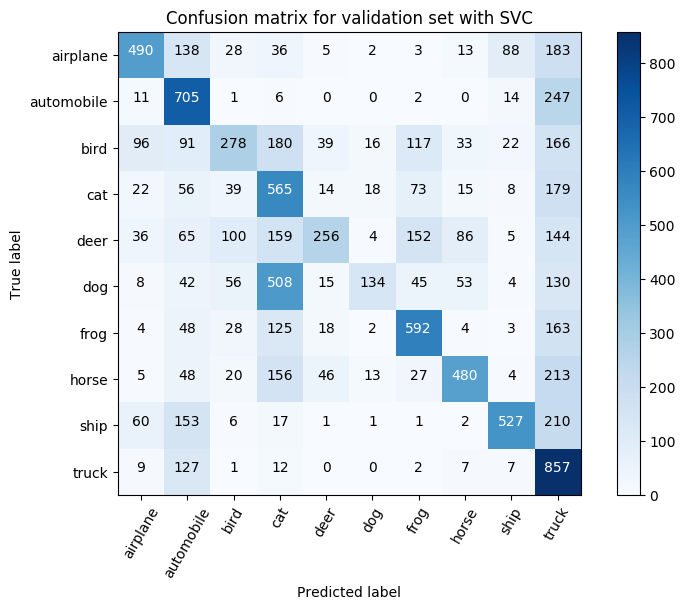

In [35]:
y_predict_raw = model.predict(X_validate)
y_predict = np.argmax(y_predict_raw, axis=1, out=None)
y_val = np.argmax(Y_validate, axis=1, out=None)

labels = sorted(list(set(cifar10_dataset.train.class_labels)))
print('Labels: ' + str(labels))
plot_tools.plot_confusion_matrix(y_val,y_predict, classes=cifar10_dataset.classes, fig_size=(8,6),
                              normalize=True, title='Confusion matrix for validation set with SVC')


In [36]:
start = time.time()
print('Classification report:')
print(skm.classification_report(y_val, y_predict, target_names=cifar10_dataset.classes))
validate_accuracy = skm.accuracy_score(y_val, y_predict, normalize=True)
print('Validation accuracy score: ' + str(validate_accuracy))
end = time.time()
print('[ Step 8] Generating classification on validation dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

Classification report:
             precision    recall  f1-score   support

   airplane       0.66      0.50      0.57       986
 automobile       0.48      0.72      0.57       986
       bird       0.50      0.27      0.35      1038
        cat       0.32      0.57      0.41       989
       deer       0.65      0.25      0.37      1007
        dog       0.71      0.13      0.23       995
       frog       0.58      0.60      0.59       987
      horse       0.69      0.47      0.56      1012
       ship       0.77      0.54      0.63       978
      truck       0.34      0.84      0.49      1022

avg / total       0.57      0.49      0.48     10000

Validation accuracy score: 0.4884
[ Step 8] Generating classification on validation dataset in 12.844324 ms


# Step 5 : Test dataset

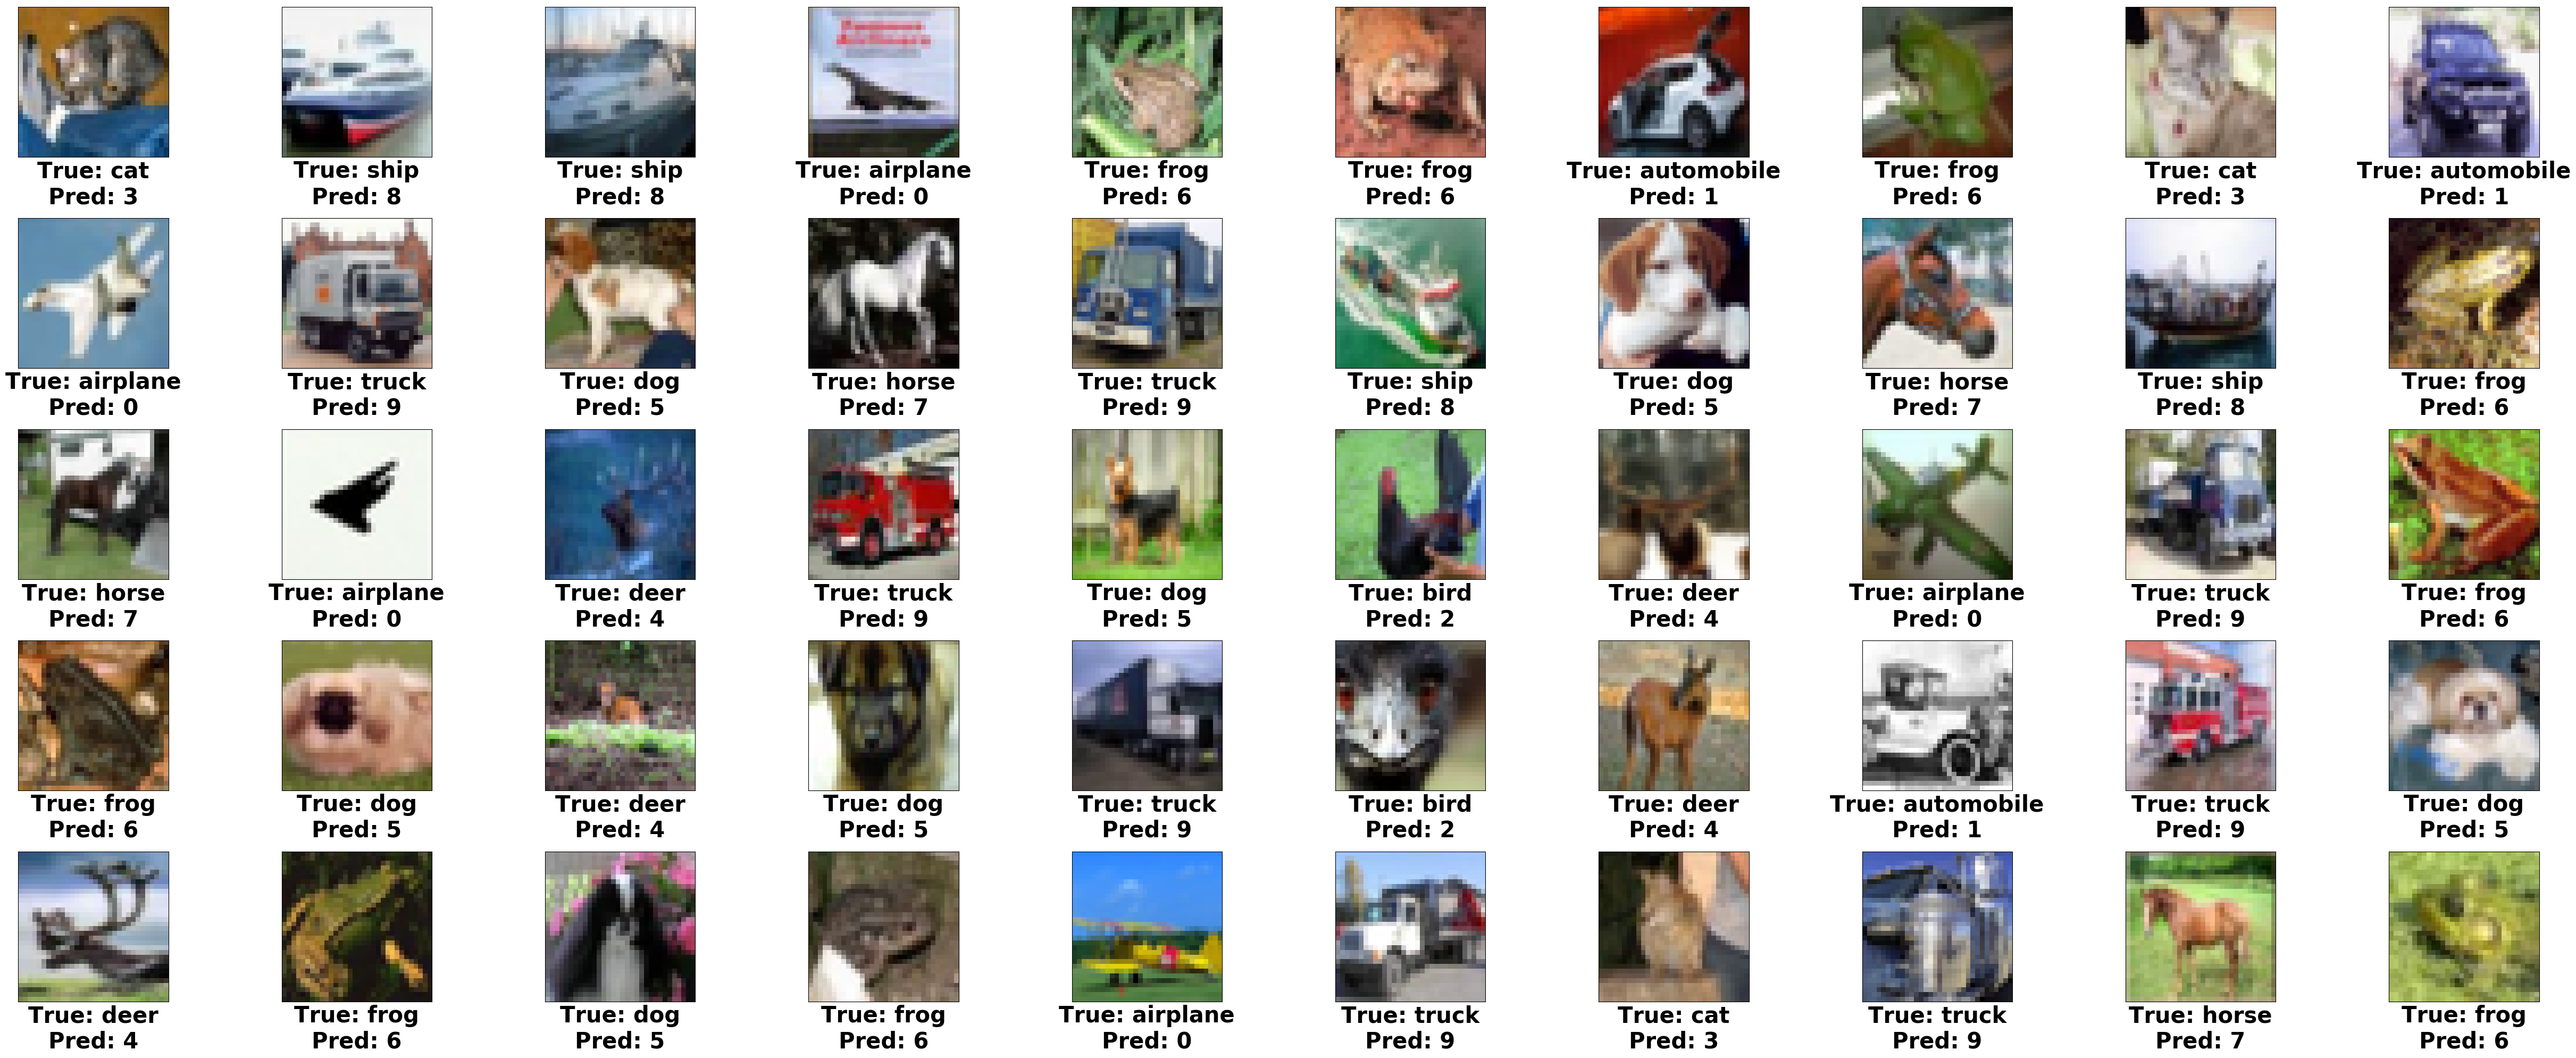

True

In [37]:
y_predict_raw = model.predict(X_test)
y_predict = np.argmax(y_predict_raw, axis=1, out=None)
y_val = np.argmax(Y_test, axis=1, out=None)

cifar10_dataset.plot_images(cifar10_dataset.test.data[:50], cifar10_dataset.test.class_names[:50], cls_pred=y_val[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=30, convert=True)




Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Confusion matrix, without normalization
[[510 117  26  29   3   0   7   1 104 203]
 [  3 747   3   8   0   0   1   0  10 228]
 [ 85  94 266 179  35  18 102  46  20 155]
 [ 20  65  38 556  20  18  78  22   8 175]
 [ 31  59 109 180 209   3 164  98  10 137]
 [  4  31  63 529  16 130  30  59   9 129]
 [  5  43  24 124  18   1 601   4   2 178]
 [ 10  42  18 145  28  19  22 473   2 241]
 [ 67 161   4  17   0   0   2   3 529 217]
 [ 11 148   3  14   1   0   2   2   7 812]]
Normalized confusion matrix
[[ 0.51   0.117  0.026  0.029  0.003  0.     0.007  0.001  0.104  0.203]
 [ 0.003  0.747  0.003  0.008  0.     0.     0.001  0.     0.01   0.228]
 [ 0.085  0.094  0.266  0.179  0.035  0.018  0.102  0.046  0.02   0.155]
 [ 0.02   0.065  0.038  0.556  0.02   0.018  0.078  0.022  0.008  0.175]
 [ 0.031  0.059  0.109  0.18   0.209  0.003  0.164  0.098  0.01   0.137]
 [ 0.004  0.031  0.063  0.529  0.016  0.13   0.03   0.059  0.009  0.129]
 [ 0.005  0.043  0.024  

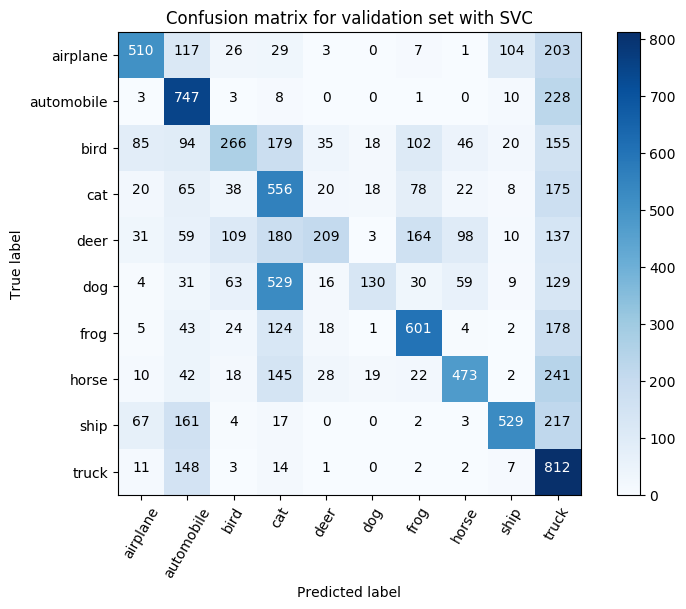

In [39]:
labels = sorted(list(set(cifar10_dataset.train.class_labels)))
print('Labels: ' + str(labels))
plot_tools.plot_confusion_matrix(y_val,y_predict, classes=cifar10_dataset.classes, fig_size=(8,6),
                              normalize=True, title='Confusion matrix for validation set with SVC')


In [40]:
start = time.time()
print('Classification report:')
print(skm.classification_report(y_val, y_predict, target_names=cifar10_dataset.classes))
validate_accuracy = skm.accuracy_score(y_val, y_predict, normalize=True)
print('Test accuracy score: ' + str(validate_accuracy))
end = time.time()
print('[ Step 8] Generating classification on validation dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

Classification report:
             precision    recall  f1-score   support

   airplane       0.68      0.51      0.58      1000
 automobile       0.50      0.75      0.60      1000
       bird       0.48      0.27      0.34      1000
        cat       0.31      0.56      0.40      1000
       deer       0.63      0.21      0.31      1000
        dog       0.69      0.13      0.22      1000
       frog       0.60      0.60      0.60      1000
      horse       0.67      0.47      0.55      1000
       ship       0.75      0.53      0.62      1000
      truck       0.33      0.81      0.47      1000

avg / total       0.56      0.48      0.47     10000

Test accuracy score: 0.4833
[ Step 8] Generating classification on validation dataset in 12.790680 ms


# Step 6 : Write the predictions to CSV file

In [44]:
import pandas as pd
start = time.time()
indices = np.arange(1, len(Y_test)+1)
predictions = np.column_stack((indices, y_val))
output_directory = '../logs/cifar10/' + str(file_no).zfill(2) + '_tf_cnn/exp_no_' + str(exp_no).zfill(3) + '/'
file_utils.mkdir_p(output_directory)
output_csv_file = output_directory + '02_' + str(exp_no).zfill(3) + '.csv'
column_names = ['id', 'label']
predict_test_df = pd.DataFrame(data=predictions, columns=column_names)
predict_test_df.to_csv(output_csv_file, index=False)
end = time.time()
print('[ Step 11] Writing the test data to file: %s in %.6f ms' %(output_csv_file, (end-start)*1000))
total_time += (end-start)

[ Step 11] Writing the test data to file: ../logs/cifar10/20_tf_cnn/exp_no_003/02_003.csv in 123.044014 ms


# Step 7 : Write the notebook to HTML file

In [45]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [46]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

<IPython.core.display.Javascript object>

In [47]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [48]:
current_file = './' + theNotebook + '.ipynb'
output_file = output_directory + str(file_no).zfill(2) + '_exp_no_' + str(exp_no) + '_' + theNotebook + '.html'
print('Current file: ' + str(current_file))
print('Output file: ' + str(output_file))
file_utils.mkdir_p(output_directory) 
output_HTML(current_file, output_file)

Current file: ./tfl_CIFAR_10_CNN_Test.ipynb
Output file: ../logs/cifar10/20_tf_cnn/exp_no_003/20_exp_no_3_tfl_CIFAR_10_CNN_Test.html

